**Creates an appropriate model for the CIFAR-10 dataset, using CNN. Utilizes data augmentation and dropouts.
The output model and graphs are saved in the same folder.**

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

*Your working code here*

# Defining the Network

In [9]:

## Class and Function Definitions.
class ConvNet(nn.Module):
    """Contains two functions:
    i) Creates the Convolutional Network with appropriate Conv2d and MaxPooling layers
    ii) Conducts the forward propogation each propogation"""

    def __init__(self):
        """Creates a Convolutional Network with 2 colvolutional and 1 maxpooling layer, followed by
        2 linear layers with Dropouts"""
        super(ConvNet, self).__init__()
        self.drpt = nn.Dropout(p=0.5)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 32, (3, 3))
        self.conv2 = nn.Conv2d(32, 64, (3, 3))
        self.conv3 = nn.Conv2d(64, 128, (3, 3))
        self.fc1 = nn.Linear(128 * 2 * 2, 512)  
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        """Forward Propogation, uses 2 convolutional layers that use maxpooling. Then uses 2 linear
        layer, the first one of which uses dropouts with p = 0.5."""        
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.drpt(self.fc1(x)))
        x = F.relu(self.drpt(self.fc2(x)))
        x = self.fc3(x)## No Softmax required, already included in cross entropy loss_function
        return x

# Training 

In [10]:
def train(model, data_loader, loss_function, optimizer, DEVICE):
    """Trains the model using crossentropy as loss function, prints the accuracy based on proportion
    model.train() of correct predictions."""
    epoch_loss = 0
    correct_pred = 0
    total_samples = 0

    for images, labels in data_loader:
        ## To get GPU support for the images and labels. Assigns the Tensors to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        ## Forward pass
        outputs = model(images)
        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        
        ## Backward and optimize
        loss.backward()
        optimizer.step()

        ## Finding the amount of loss. The more the loss, the more the calibration
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_pred += (predicted == labels).sum().item()

    accuracy = correct_pred / total_samples * 100
    avg_loss = epoch_loss / len(data_loader) 

    return avg_loss, accuracy

# Testing

In [11]:
def test(model, data_loader, loss_function, DEVICE):
    """Tests the validation set and gives the accuracy and loss score. """

    model.eval()
    epoch_loss = 0
    correct_pred = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            loss = loss_function(outputs, labels)

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_pred += (predicted == labels).sum().item()

    accuracy = correct_pred / total_samples * 100
    avg_loss = epoch_loss / len(data_loader)

    return avg_loss, accuracy

# The Plotting Functions

In [12]:
def accuracy_plot(train_acc, test_acc):
    """Plots the accuracy graph for the training and validation sets using matplotlib"""

    plt.plot(train_acc, '-o')
    plt.plot(test_acc, '-o')
    plt.title('Training vs Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (Probability)')
    plt.legend(['Training', 'Validation'])
    plt.savefig("accuracy-torch.png")


def loss_plot(train_loss, test_loss):
    """Plots the loss graph for the training and validation sets using matplotlib"""

    plt.plot(train_loss, '-o')
    plt.plot(test_loss, '-o')
    plt.title('Training vs Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Cross Entropy)')
    plt.legend(['Training', 'Validation'])
    plt.savefig("loss-torch.png")

# The Wrapper Function

In [13]:
def process_cifar():
    """This function defines the main global variables and then applies data augmentations. It then calls the model and starts forward and
    back propogation to train the model."""

    ## DEVICE configuration. The code works much faster when running on the GPU.
    ## torch.cuda.is_available() gives True only when proper gpu support libraries for 
    ## cuda have been installed.
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    ## Main parameters 
    NUM_EPOCHS = 100 ## These are the number of epochs. Make it whatever you want. Default value is 100
    BATCH_SIZE = 16
    LEARNING_RATE = 0.002 ## Default value 0.001. Smaller steps ensure no overshooting, however, can decrease 
    ## loss function very slowly.
    MOMENTUM = 0.9

    ## Images of the dataset are Tensors with each value being from 0 to 1. We are transforming them to Tensors
    ## having value from -1 to 1. I have also done data augmentation, to create a better model that can have a 
    ## better accuracy on the validation set. However, that requires much more computational power.
    transform = transforms.Compose([#transforms.ToPILImage(),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ColorJitter(brightness=0.5),
                                    transforms.RandomRotation(degrees=45),
                                    transforms.RandomVerticalFlip(p=0.05),
                                    transforms.RandomGrayscale(p=0.2),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    ## Dataset stores the samples and their corresponding labels
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


    ## DataLoader wraps an iterable around the Dataset to enable easy access to the samples. It simplifies
    ## the process for python.
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                                batch_size=BATCH_SIZE,
                                                shuffle=True, num_workers=2)

    test_loader = torch.utils.data.DataLoader(test_dataset,
                                                batch_size=BATCH_SIZE,
                                                num_workers=2,
                                                shuffle=False) ## We don't wish to shuffle this. The images should
    ## have their designated labels only

    model = ConvNet().to(DEVICE) ## To get GPU support

    ## Keeping track of training accuracy and loss through the model
    train_loss_values = []
    train_acc_values = []
    test_loss_values = []
    test_acc_values = []

    loss_function = nn.CrossEntropyLoss() ## This is multiclass problem. Cross Entropy is the best fit.
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

    for epoch in range(NUM_EPOCHS):
        print(f'Epoch: {epoch+1}/{NUM_EPOCHS}')
        print('<-------------->')
        train_loss, train_acc = train(model, train_loader, loss_function, optimizer, DEVICE)
        test_loss, test_acc = test(model, test_loader, loss_function, DEVICE)

        print(f'Training Info: Accuracy: {train_acc:3f}%, Loss: {train_loss:3f}')
        print(f'Testing Info: Accuracy: {test_acc:3f}%, Loss: {test_loss:3f}')

        train_loss_values.append(train_loss)
        train_acc_values.append(train_acc)
        test_loss_values.append(test_loss)
        test_acc_values.append(test_acc)
        
        print('\n')

    torch.save(model.state_dict(), 'cifar-10-model-torch.h5')

    accuracy_plot(train_acc_values, test_acc_values)
    plt.clf()
    loss_plot(train_loss_values, test_loss_values)

## Main function

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1/100
<-------------->
Training Info: Accuracy: 18.030000%, Loss: 2.168959
Testing Info: Accuracy: 29.120000%, Loss: 1.934546


Epoch: 2/100
<-------------->
Training Info: Accuracy: 35.084000%, Loss: 1.783554
Testing Info: Accuracy: 40.210000%, Loss: 1.644367


Epoch: 3/100
<-------------->
Training Info: Accuracy: 42.888000%, Loss: 1.585355
Testing Info: Accuracy: 45.020000%, Loss: 1.535424


Epoch: 4/100
<-------------->
Training Info: Accuracy: 47.078000%, Loss: 1.468031
Testing Info: Accuracy: 48.380000%, Loss: 1.444938


Epoch: 5/100
<-------------->
Training Info: Accuracy: 50.940000%, Loss: 1.371166
Testing Info: Accuracy: 51.750000%, Loss: 1.357408


Epoch: 6/100
<-------------->
Training Info: Accuracy: 53.658000%, Loss: 1.300229
Testing Info: Accuracy: 54.890000%, Loss: 1.265394


Epoch: 7/100
<-------------->
Training Info: Accuracy: 56.224000%, Loss: 1.239270
Testing Info: Accuracy: 56.85000

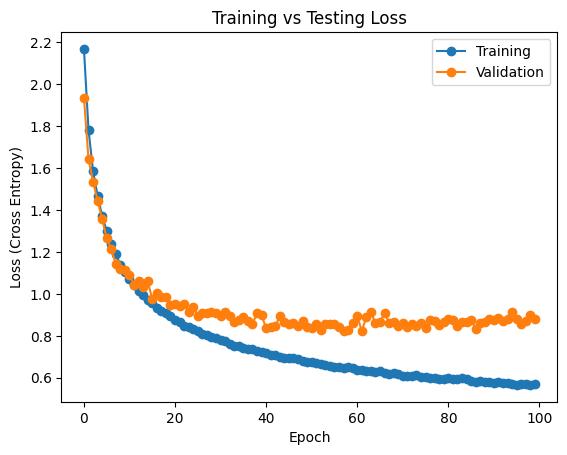

In [14]:

if __name__ == '__main__':
    process_cifar()